In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


2025-06-23 04:50:59.682823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750654259.862969      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750654259.913520      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Cleaning


In [2]:
df = pd.read_csv("/kaggle/input/steam-games-reviews-and-rankings/steam_game_reviews.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992153 entries, 0 to 992152
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review          991650 non-null  object
 1   hours_played    992153 non-null  object
 2   helpful         992153 non-null  object
 3   funny           992153 non-null  object
 4   recommendation  992153 non-null  object
 5   date            992153 non-null  object
 6   game_name       992153 non-null  object
 7   username        992072 non-null  object
dtypes: object(8)
memory usage: 60.6+ MB


In [4]:
df["hours_played"] = pd.to_numeric(df["hours_played"], errors="coerce")
df["helpful"] = pd.to_numeric(df["helpful"], errors="coerce")
df["funny"] = pd.to_numeric(df["funny"], errors="coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992153 entries, 0 to 992152
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review          991650 non-null  object 
 1   hours_played    918437 non-null  float64
 2   helpful         989265 non-null  float64
 3   funny           991163 non-null  float64
 4   recommendation  992153 non-null  object 
 5   date            992153 non-null  object 
 6   game_name       992153 non-null  object 
 7   username        992072 non-null  object 
dtypes: float64(3), object(5)
memory usage: 60.6+ MB


In [5]:
df.dropna(inplace=True)
df.isnull().sum()

review            0
hours_played      0
helpful           0
funny             0
recommendation    0
date              0
game_name         0
username          0
dtype: int64

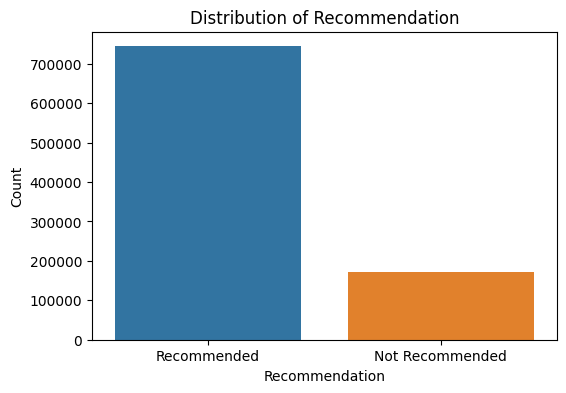

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='recommendation', data=df)
plt.title('Distribution of Recommendation')
plt.xlabel('Recommendation')
plt.ylabel('Count')
plt.show()

In [7]:
recommended = df[df['recommendation'] == 'Recommended']
not_recommended = df[df['recommendation'] == 'Not Recommended']

n_not_recommended = 20000
n_recommended = int(n_not_recommended * 8 / 2)

sampled_recommended = recommended.sample(n=n_recommended, random_state=42)
sampled_not_recommended = not_recommended.sample(n=n_not_recommended, random_state=42)

df_sample = pd.concat([sampled_recommended, sampled_not_recommended]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_sample['recommendation'].value_counts())

recommendation
Recommended        80000
Not Recommended    20000
Name: count, dtype: int64


# Data Preproccesing

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [10]:
def preprocess_text(text):
    # 1. Text Normalization (Lowercasing)
    text = text.lower()

    # 2. Tokenization
    tokens = word_tokenize(text)

    # 3. Stopword Removal and Lemmatization
    processed_tokens = []
    for word in tokens:
        if word.isalpha() and word not in stop_words:
            lemma = lemmatizer.lemmatize(word)
            processed_tokens.append(lemma)

    # Join tokens back into a string
    return " ".join(processed_tokens)

In [11]:
df_sample['processed_review'] = df_sample['review'].apply(preprocess_text)

print("Processed Reviews:")
print(df_sample['processed_review'].head())

Processed Reviews:
0                     vvbetter valorantbetter valorant
1    game named nfs heat cell shaded map basically ...
2              great time killer especially steam deck
3    early access review thing ca wash hand really ...
4    fact game even next gen graphic pc kind insane...
Name: processed_review, dtype: object


# EDA

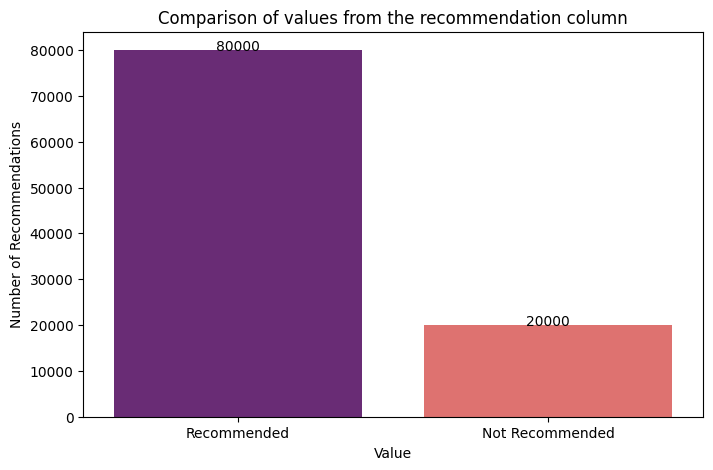

In [12]:
count_values = df_sample['recommendation'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=count_values.index, y=count_values.values, palette='magma')
plt.title('Comparison of values ​​from the recommendation column')
plt.xlabel('Value')
plt.ylabel('Number of Recommendations')
for i, v in enumerate(count_values.values):
    plt.text(i, v + 0.1, str(v), ha='center')

plt.show()

In [13]:
data = df_sample['date']
df2 = pd.DataFrame(data)

def preprocess_dates(date_str):
    if ',' not in date_str:
        return f"{date_str}, 2024"
    return date_str

df_sample['date'] = df_sample['date'].apply(preprocess_dates)

df_sample['date'] = pd.to_datetime(df_sample['date'], format='mixed')

df_sample['year'] = df_sample['date'].dt.year

recommendation_counts_per_year = df_sample.groupby(['year', 'recommendation']).size().unstack(fill_value=0)

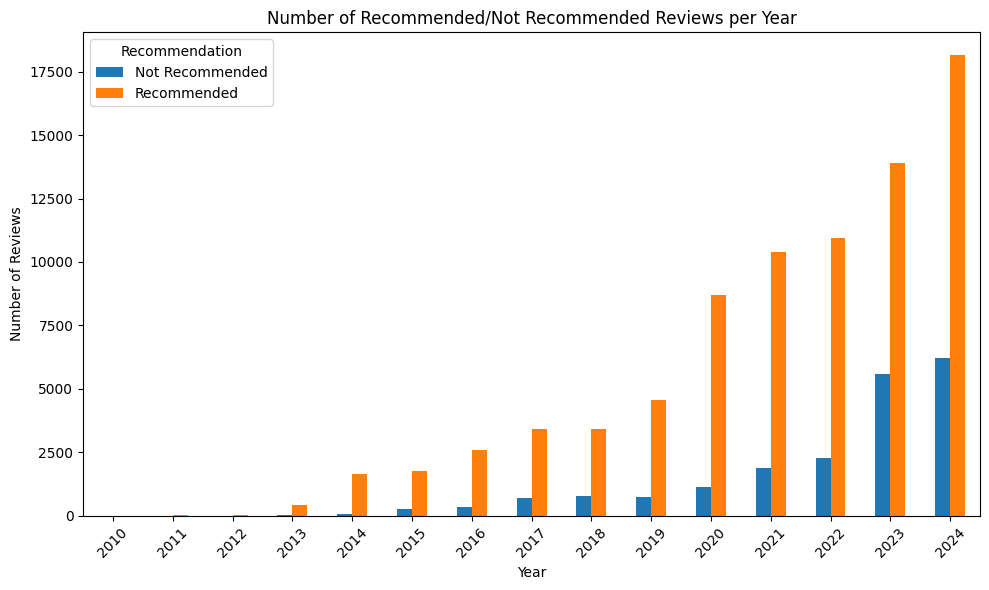

In [14]:
recommendation_counts_per_year.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Recommended/Not Recommended Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Recommendation')
plt.tight_layout()
plt.show()

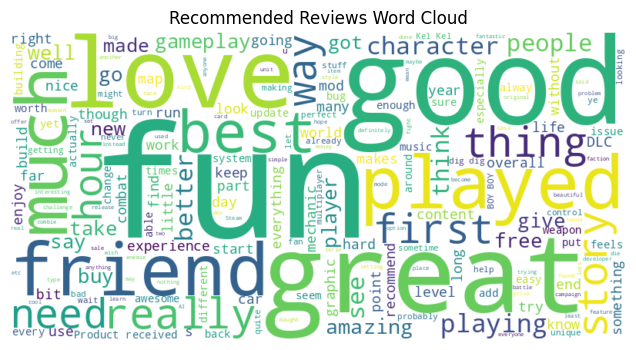

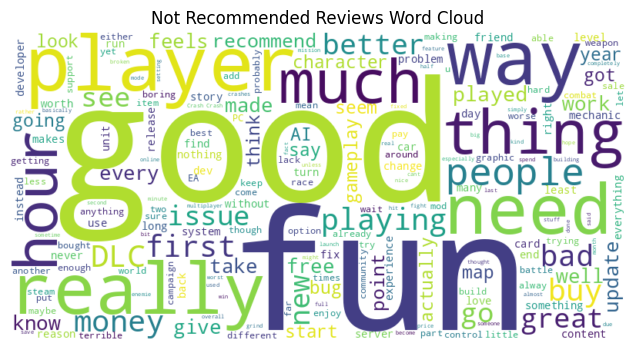

In [15]:
recommended_reviews = " ".join(df_sample[df_sample['recommendation'].str.lower() == 'recommended']['review'].dropna())
not_recommended_reviews = " ".join(df_sample[df_sample['recommendation'].str.lower() == 'not recommended']['review'].dropna())

stopwords = set(STOPWORDS)
stopwords.update(["game", "games", "play", "time", "one", "get", "early", "access", "make", "even", "review", "want", "still", "will", "feel", "lot", "now"]) # Adding specific game-related words to the list of stopwords

if len(recommended_reviews) > 0:
  wc_recommended = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(recommended_reviews)
  plt.figure(figsize=(8, 4))
  plt.title("Recommended Reviews Word Cloud")
  plt.imshow(wc_recommended, interpolation="bilinear")
  plt.axis("off")
  plt.show()
else:
    print("No 'recommended' reviews found to generate word cloud.")

if len(not_recommended_reviews) > 0:
  wc_not_recommended = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(not_recommended_reviews)
  plt.figure(figsize=(8, 4))
  plt.title("Not Recommended Reviews Word Cloud")
  plt.imshow(wc_not_recommended, interpolation="bilinear")
  plt.axis("off")
  plt.show()
else:
  print("No 'not recommended' reviews found to generate word cloud.")

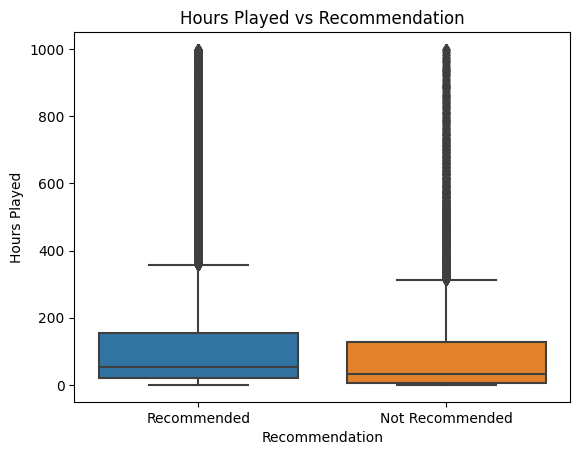

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

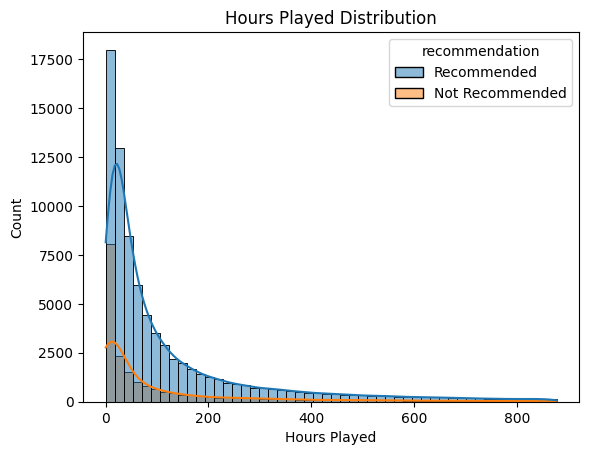

In [16]:
# Distribution of hours played for each recommendation type
sns.boxplot(data=df_sample, x='recommendation', y='hours_played')
plt.title("Hours Played vs Recommendation")
plt.xlabel("Recommendation")
plt.ylabel("Hours Played")
plt.show()

# Filter extreme outliers for better visualisation
df_filtered = df_sample[df_sample['hours_played'] < df_sample['hours_played'].quantile(0.99)]
sns.histplot(data=df_filtered, x='hours_played', hue='recommendation', kde=True, bins=50)
plt.title("Hours Played Distribution")
plt.xlabel("Hours Played")
plt.show()

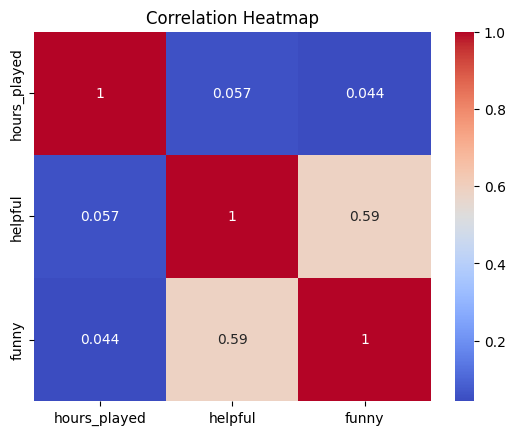

In [17]:
sns.heatmap(df_sample[['hours_played', 'helpful', 'funny']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

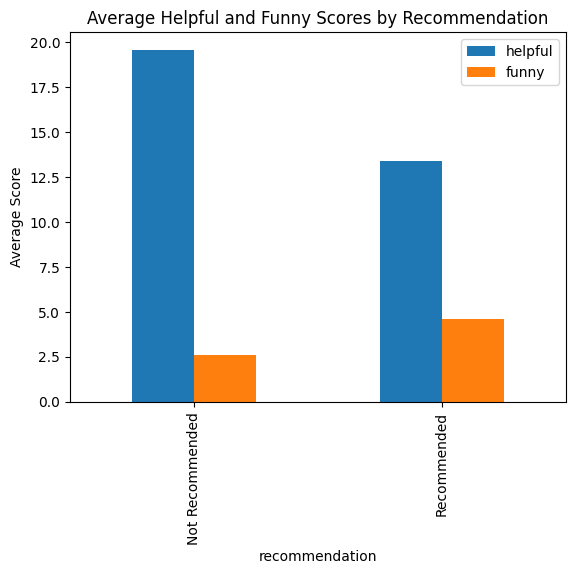

In [18]:
df_sample.groupby('recommendation')[['helpful', 'funny']].mean().plot(kind='bar')
plt.title("Average Helpful and Funny Scores by Recommendation")
plt.ylabel("Average Score")
plt.show()

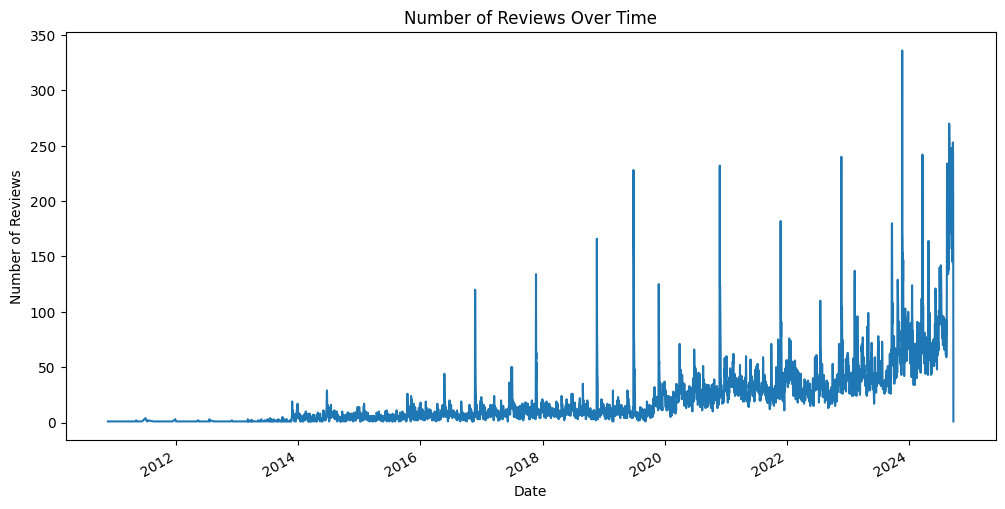

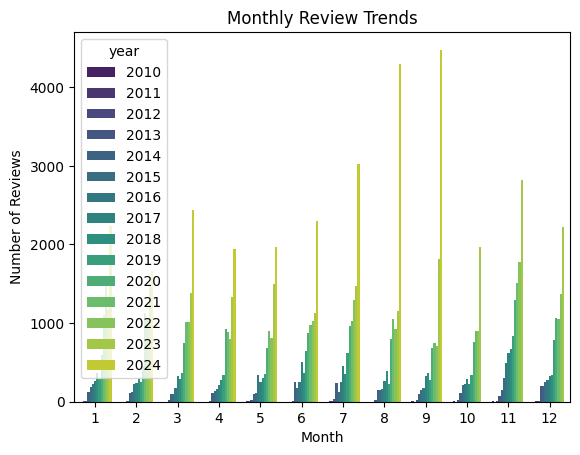

In [19]:
df_sample['date'].value_counts().sort_index().plot(kind='line', figsize=(12, 6))
plt.title("Number of Reviews Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.show()

# Extract month or year for additional trends
df_sample['year'] = df_sample['date'].dt.year
df_sample['month'] = df_sample['date'].dt.month

# Monthly trends
sns.countplot(data=df_sample, x='month', hue='year', palette='viridis')
plt.title("Monthly Review Trends")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.show()

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['processed_review'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"This matrix has {tfidf_matrix.shape[0]} documents (reviews) and {tfidf_matrix.shape[1]} unique features (words).")
print("TF-IDF features successfully generated. This sparse matrix is ready for Traditional ML Models.")


TF-IDF Matrix Shape: (100000, 5000)
This matrix has 100000 documents (reviews) and 5000 unique features (words).
TF-IDF features successfully generated. This sparse matrix is ready for Traditional ML Models.


In [21]:
glove_embedding_dim = 100
glove_path = 'glove.6B.100d.txt'

In [22]:
def load_glove_embeddings(path):
    embeddings_index = {}
    if not os.path.exists(path):
        print(f"ERROR: GloVe file '{path}' not found.")
        return {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [23]:
embedding_index = load_glove_embeddings(glove_path)

ERROR: GloVe file 'glove.6B.100d.txt' not found.


In [24]:
def create_avg_word_embedding(text_tokens_string, embeddings_index, embedding_dim):
    tokens = text_tokens_string.split()
    vectors = []
    for word in tokens:
        if word in embeddings_index:
            vectors.append(embeddings_index[word])
    
    if not vectors:
        return np.zeros(embedding_dim)
    
    return np.mean(vectors, axis=0)

In [25]:
df_sample['glove_features'] = df_sample['review'].apply(
    lambda x: create_avg_word_embedding(x, embedding_index, glove_embedding_dim).tolist()
)

In [26]:
glove_features_matrix = np.array(df_sample['glove_features'].tolist())

print(f"Shape of GloVe features matrix: {glove_features_matrix.shape}")

Shape of GloVe features matrix: (100000, 100)


In [27]:
class ReviewsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        return item

# Opinion Mining

In [28]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   review            100000 non-null  object        
 1   hours_played      100000 non-null  float64       
 2   helpful           100000 non-null  float64       
 3   funny             100000 non-null  float64       
 4   recommendation    100000 non-null  object        
 5   date              100000 non-null  datetime64[ns]
 6   game_name         100000 non-null  object        
 7   username          100000 non-null  object        
 8   processed_review  100000 non-null  object        
 9   year              100000 non-null  int32         
 10  month             100000 non-null  int32         
 11  glove_features    100000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(2), object(6)
memory usage: 8.4+ MB


In [29]:
df_sample[['review', 'processed_review']].sample(5)

,review,processed_review
51297,2018 If you have beaten Civ V 100 times and at...,beaten civ v time higher difficulty level need...
37419,2021 Was a great game. Then they tried to chan...,great game tried change add bunch new feature ...
60021,2022 asdawasd,asdawasd
83023,2021 Didn't know I was going to like it so muc...,know going like much great game
26492,2020 its like black ops 3 multiplayer if black...,like black ops multiplayer black ops multiplay...


In [30]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_opinions(text):
    doc = nlp(text)
    opinions = []
    for token in doc:
        # Adjective modifying noun (explicit opinion)
        if token.dep_ == "amod" and token.head.pos_ == "NOUN":
            opinions.append((token.text, token.head.text))  # (opinion, target)
    return opinions

df_sample['explicit_opinions'] = df_sample['processed_review'].apply(extract_opinions)

In [31]:
from nltk.corpus import sentiwordnet as swn

def get_sentiment_score(word):
    try:
        synsets = list(swn.senti_synsets(word))
        if synsets:
            s = synsets[0]
            return s.pos_score() - s.neg_score()
        else:
            return 0.0
    except:
        return 0.0

df_sample['explicit_sentiment_score'] = df_sample['explicit_opinions'].apply(
    lambda pairs: sum([get_sentiment_score(op[0]) for op in pairs]) / len(pairs) if pairs else 0
)

In [32]:
!pip install xformers

ERROR: Invalid requirement: 'xformers.': Expected end or semicolon (after name and no valid version specifier)
    xformers.
            ^


In [33]:
from transformers import pipeline

# Load the model with truncation
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english", 
    truncation=True,
    framework="pt"
)

# Truncate input at 512 tokens safely using tokenizer
def safe_sentiment(review):
    try:
        # Truncate if needed by slicing string (rough estimate: 512 tokens ~ 700-800 words max)
        if len(review.split()) > 500:
            review = " ".join(review.split()[:500])
        result = sentiment_pipeline(review)[0]
        return result['label']
    except:
        return "ERROR"

# Apply to your DataFrame (sample or small chunk first)
df_sample['implicit_sentiment'] = df_sample['review'].apply(safe_sentiment)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [34]:
from collections import Counter
from itertools import chain

all_targets = list(chain.from_iterable([ [target for _, target in pair] for pair in df_sample['explicit_opinions']]))
target_counts = Counter(all_targets)
print(target_counts.most_common(10))

[('game', 65321), ('time', 12581), ('review', 12322), ('thing', 7010), ('story', 6005), ('way', 5642), ('player', 5340), ('hour', 4655), ('experience', 4189), ('fun', 3977)]


In [35]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   review                    100000 non-null  object        
 1   hours_played              100000 non-null  float64       
 2   helpful                   100000 non-null  float64       
 3   funny                     100000 non-null  float64       
 4   recommendation            100000 non-null  object        
 5   date                      100000 non-null  datetime64[ns]
 6   game_name                 100000 non-null  object        
 7   username                  100000 non-null  object        
 8   processed_review          100000 non-null  object        
 9   year                      100000 non-null  int32         
 10  month                     100000 non-null  int32         
 11  glove_features            100000 non-null  object        
 12  exp

In [36]:
df_sample[['explicit_opinions','explicit_sentiment_score','implicit_sentiment']]

,explicit_opinions,explicit_sentiment_score,implicit_sentiment
0,[],0.000000,NEGATIVE
1,"[(shaded, map)]",0.000000,NEGATIVE
2,"[(great, time)]",0.000000,POSITIVE
3,"[(early, thing)]",0.000000,POSITIVE
4,"[(next, kind), (insane, game), (good, game), (...",-0.250000,NEGATIVE
...,...,...,...
99995,"[(good, game), (worth, game), (based, game), (...",0.125000,POSITIVE
99996,[],0.000000,POSITIVE
99997,"[(creative, world), (colourful, world), (under...",0.154412,POSITIVE
99998,"[(portal, sound)]",0.000000,NEGATIVE


# Aspect-Based Sentiment Analysis (ABSA)

In [37]:
def extract_aspects(text):
    doc = nlp(text)
    return [chunk.text.lower() for chunk in doc.noun_chunks if len(chunk.text) > 1]

df_sample['aspects'] = df_sample['processed_review'].apply(extract_aspects)

In [ ]:
def get_sentiment_score(word):
    try:
        synsets = list(swn.senti_synsets(word))
        if synsets:
            s = synsets[0]
            return s.pos_score() - s.neg_score()
    except:
        return 0.0
    return 0.0

def extract_aspect_sentiment(text):
    doc = nlp(text)
    aspect_sentiment_pairs = []
    for token in doc:
        # If adjective modifies a noun
        if token.dep_ == "amod" and token.head.pos_ == "NOUN":
            sentiment_score = get_sentiment_score(token.text)
            sentiment_label = "positive" if sentiment_score > 0.1 else "negative" if sentiment_score < -0.1 else "neutral"
            aspect_sentiment_pairs.append((token.head.text.lower(), sentiment_label))
    return aspect_sentiment_pairs

df_sample['aspect_sentiment'] = df_sample['processed_review'].apply(extract_aspect_sentiment)

In [ ]:
df_sample.info()

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm.autonotebook import tqdm
model_name = "yangheng/deberta-v3-base-absa-v1.1" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
reviews = df_sample['review'].tolist()

results = aspect_extractor.extract_aspect(
    inference_source=reviews,
    save_result=False,
    print_result=False
)

# Append results to DataFrame
df_sample['pyabsa_aspects'] = [r.get('aspect', []) for r in results]
df_sample['pyabsa_sentiments'] = [r.get('sentiment', []) for r in results]
df_sample['pyabsa_aspect_sentiment_pairs'] = [
    list(zip(r.get('aspect', []), r.get('sentiment', []))) for r in results
]

In [ ]:
reviews = df_sample['review'].head(100).tolist()

# Run ABSA extraction
results = aspect_extractor.extract_aspect(
    inference_source=reviews,
    save_result=False,
    print_result=False
)

In [ ]:
for res in results[:5]:
    print("Review:", res['sentence'])
    print("Aspects:", res['aspect'])
    print("Polarities:", res['sentiment'])
    print("-" * 40)

In [ ]:
absa_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    device=0  # use CUDA if available
)

In [ ]:
def extract_aspects(text):
    """Extract noun phrases (1-3 words) as candidate aspects."""
    doc = nlp(text)
    return list(set(chunk.text.lower() for chunk in doc.noun_chunks if 1 <= len(chunk.text.split()) <= 3))

def bert_absa(text):
    """Run BERT-ABSA on a single review."""
    aspects = extract_aspects(text)
    results = []
    for asp in aspects:
        try:
            formatted_text = text.replace(asp, f"[ASP] {asp} [ASP]", 1)
            pred = absa_pipeline(formatted_text)[0]
            results.append({
                'aspect': asp,
                'sentiment': pred['label'],
                'confidence': round(pred['score'], 3)
            })
        except:
            continue
    return results

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df_sample['bert_absa'] = df_sample['review'].progress_apply(bert_absa)

In [ ]:
df_sample.to_csv("steam_game_reviews_sample_ABSA.csv")